In [313]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import time
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif, chi2
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

from scipy.stats import chi2_contingency
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [314]:
def select_features(X, y):
    ##Label encode y if it is an object
    if y.dtype == 'object':
        y = LabelEncoder().fit_transform(y)

        #y = pd.factorize(y)[0]

    
    # Calculate correlation coefficients and p-values between features and target variable
    corrs, p_values = [], []
    for feature in X.columns:
        ##We had also categorical columns before, but now we are using only numerical columns
        """  if X[feature].dtype == 'object':
            contingency_table = pd.crosstab(X[feature], y)
            _, p, _, _ = chi2_contingency(contingency_table)
            corrs.append(np.sqrt(p / (p + X[feature].nunique() - 1)))
        else: """
        corr, p = f_classif(X[[feature]], y)
        corrs.append(corr[0])
        p_values.append(p)
    
    # Combine correlation coefficients and p-values into a single DataFrame
    corr_df = pd.DataFrame({'Feature': X.columns, 'Correlation': corrs, 'P-Value': p_values})
    corr_df = corr_df.sort_values(by='Correlation', ascending=False).reset_index(drop=True)
    
    # Select features with significant correlation and p-value
    significant_features = corr_df.loc[(corr_df['Correlation'] > 0) & (corr_df['P-Value'] < 0.05), 'Feature'].tolist()
    
    
    return significant_features

In [315]:
def evaluate_models(X, y, classifiers, preprocessing_methods, splitting_strategy, k=5):
    results = {}
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    for preprocessing_method in preprocessing_methods:
        for clf in classifiers:
            clf_name = clf.__class__.__name__
            f1_scores = []
            preprocess_times = []
            train_times = []
            for train_index, test_index in kf.split(X, y):
                # Split dataset into train and test sets for this fold
                X_train, X_test = X.iloc[train_index], X.iloc[test_index]
                y_train, y_test = y.iloc[train_index], y.iloc[test_index]

                # Preprocess data for this fold
                preprocess_start_time = time.time()
                if preprocessing_method == "none":
                    X_train_preprocessed = X_train
                    X_test_preprocessed = X_test
                elif preprocessing_method == "featureselection":
                    significant_features = select_features(X_train, y_train)
                    #Print the lenght of X.columns and lenght of significant features
                    print("Number of features: ", len(X_train.columns))
                    print("Number of significant features: ", len(significant_features))
                    X_train_preprocessed = X_train[significant_features]
                    X_test_preprocessed = X_test[significant_features]
                elif preprocessing_method == "scaler":
                    scaler = StandardScaler()
                    X_train_preprocessed = scaler.fit_transform(X_train)
                    X_test_preprocessed = scaler.transform(X_test)
                else:  # "all"
                    significant_features = select_features(X_train, y_train)
                    print("Number of features: ", len(X_train.columns))
                    print("Number of significant features: ", len(significant_features))
                    scaler = StandardScaler()
                    X_train_preprocessed = scaler.fit_transform(X_train[significant_features])
                    X_test_preprocessed = scaler.transform(X_test[significant_features])
                preprocess_end_time = time.time()
                preprocess_times.append(preprocess_end_time - preprocess_start_time)

                # Train and evaluate model for this fold
                train_start_time = time.time()
                clf.fit(X_train_preprocessed, y_train)
                train_end_time = time.time()
                train_times.append(train_end_time - train_start_time)

                y_pred = clf.predict(X_test_preprocessed)
                f1_scores.append(f1_score(y_test, y_pred, average="weighted"))

            # Compute mean F1 score across all folds for this classifier and preprocessing method
            mean_f1_score = np.mean(f1_scores)
            mean_preprocess_time = np.mean(preprocess_times)
            mean_train_time = np.mean(train_times)
            result_key = f"{clf_name}_{preprocessing_method}_{splitting_strategy}"
            results[result_key] = {"mean_f1_score": mean_f1_score,
                                   "dev_f1_score": np.std(f1_scores),
                                   "mean_preprocess_time": mean_preprocess_time,
                                   "mean_train_time": mean_train_time}
    return results


# Loading the data sets

In [316]:
##Load data
breast = pd.read_csv("preprocessed-datasets/breast-cancer-prepro.csv")
#Set index
breast.set_index("ID", inplace=True)
breast.name = "Breast Cancer"
setattr(breast, '_name', 'breast')
breast.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 285 entries, 8813129 to 8810158
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   target                   285 non-null    bool   
 1   radiusMean               285 non-null    float64
 2    textureMean             285 non-null    float64
 3    perimeterMean           285 non-null    float64
 4    areaMean                285 non-null    float64
 5    smoothnessMean          285 non-null    float64
 6    compactnessMean         285 non-null    float64
 7    concavityMean           285 non-null    float64
 8    concavePointsMean       285 non-null    float64
 9    symmetryMean            285 non-null    float64
 10   fractalDimensionMean    285 non-null    float64
 11   radiusStdErr            285 non-null    float64
 12   textureStdErr           285 non-null    float64
 13   perimeterStdErr         285 non-null    float64
 14   areaStdErr     

In [317]:
##Load loan
loan = pd.read_csv("preprocessed-datasets/loan-prepro.csv")
#Set index
loan.set_index("ID", inplace=True)
loan.name = 'Loan'
setattr(loan, '_name', 'loan')
loan.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 24341 to 8729
Columns: 158 entries, loan_amnt to target
dtypes: float64(69), int64(88), object(1)
memory usage: 12.1+ MB


In [318]:
## Load drug consumption
drug = pd.read_csv("preprocessed-datasets/drug_consumption-prepro.csv")
drug.name = 'Drug Consumption'
setattr(drug, '_name', 'drug')
drug.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1877 entries, 0 to 1876
Data columns (total 30 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Age        1877 non-null   float64
 1   Gender     1877 non-null   float64
 2   Education  1877 non-null   float64
 3   Country    1877 non-null   float64
 4   Ethnicity  1877 non-null   float64
 5   Nscore     1877 non-null   float64
 6   Escore     1877 non-null   float64
 7   Oscore     1877 non-null   float64
 8   Ascore     1877 non-null   float64
 9   Cscore     1877 non-null   float64
 10  Impulsive  1877 non-null   float64
 11  SS         1877 non-null   float64
 12  Alcohol    1877 non-null   float64
 13  Amphet     1877 non-null   float64
 14  Amyl       1877 non-null   float64
 15  Benzos     1877 non-null   float64
 16  Caff       1877 non-null   float64
 17  Cannabis   1877 non-null   float64
 18  Choc       1877 non-null   float64
 19  Coke       1877 non-null   float64
 20  Crack   

In [319]:
##Bank data
bank = pd.read_csv("preprocessed-datasets/bank-prepro.csv")
bank.name = "Bank Marketing"
setattr(bank, '_name', 'bank')
bank.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 37 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   Unnamed: 0           45211 non-null  int64
 1   age                  45211 non-null  int64
 2   default              45211 non-null  int64
 3   balance              45211 non-null  int64
 4   housing              45211 non-null  int64
 5   loan                 45211 non-null  int64
 6   duration             45211 non-null  int64
 7   campaign             45211 non-null  int64
 8   pdays                45211 non-null  int64
 9   previous             45211 non-null  int64
 10  target               45211 non-null  int64
 11  job_admin.           45211 non-null  int64
 12  job_blue-collar      45211 non-null  int64
 13  job_entrepreneur     45211 non-null  int64
 14  job_housemaid        45211 non-null  int64
 15  job_management       45211 non-null  int64
 16  job_retired          4

# Experimet setup 

In [320]:
# Define datasets
dataset_array = [breast, loan, drug, bank]
dataset_names = ["Breast Cancer", "Loan", "Drug Consumption", "Bank Marketing"]


# Define classifiers
classifiers = [RandomForestClassifier(), KNeighborsClassifier(), LogisticRegression()]

# Define preprocessing methods
preprocessing_methods = ["none", "featureselection", "scaler", "all"]

# Define splitting strategies
splitting_strategies = ["holdout", "cv"]

# Model training

In [321]:
final_results = {}
for dataset_name, dataset in zip(dataset_names, dataset_array):
    X = dataset.drop("target", axis=1)
    y = dataset["target"]

    dataset_results = {}

    for splitting_strategy in splitting_strategies:
        if splitting_strategy == "holdout":
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
            results = evaluate_models(X_train, y_train, classifiers, preprocessing_methods, splitting_strategy="holdout")
            dataset_results["holdout"] = results

        else:
            results = evaluate_models(X, y, classifiers, preprocessing_methods, splitting_strategy="cv")
            dataset_results["cv"] = results
    
    final_results[dataset_name] = dataset_results
    """ for splitting_strategy in splitting_strategies:
        if splitting_strategy == "holdout":
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
            results = evaluate_models(X_train, y_train, classifiers, preprocessing_methods, splitting_strategy="holdout")
            for (splitting_strategy, preprocessing_method, clf_name, mean_f1_score) in results:
                print(f"Dataset: {dataset.name}, Splitting strategy: {splitting_strategy}, Preprocessing method: {preprocessing_method}, Classifier: {clf_name}, Mean F1 score: {mean_f1_score}")
        else:
            results = evaluate_models(X, y, classifiers, preprocessing_methods, splitting_strategy="cv")
            for (splitting_strategy, preprocessing_method, clf_name, mean_f1_score) in results:
                print(f"Dataset: {dataset.name}, Splitting strategy: {splitting_strategy}, Preprocessing method: {preprocessing_method}, Classifier: {clf_name}, Mean F1 score: {mean_f1_score}") """

/Users/kristian/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/kristian/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html

Number of features:  30
Number of significant features:  25
Number of features:  30
Number of significant features:  26
Number of features:  30
Number of significant features:  25
Number of features:  30
Number of significant features:  26
Number of features:  30
Number of significant features:  25
Number of features:  30
Number of significant features:  25
Number of features:  30
Number of significant features:  26
Number of features:  30
Number of significant features:  25
Number of features:  30
Number of significant features:  26
Number of features:  30
Number of significant features:  25
Number of features:  30
Number of significant features:  25


/Users/kristian/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Number of features:  30
Number of significant features:  26
Number of features:  30
Number of significant features:  25


/Users/kristian/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/kristian/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html

Number of features:  30
Number of significant features:  26
Number of features:  30
Number of significant features:  25


/Users/kristian/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/kristian/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html

Number of features:  30
Number of significant features:  25
Number of features:  30
Number of significant features:  26
Number of features:  30
Number of significant features:  25
Number of features:  30
Number of significant features:  26
Number of features:  30
Number of significant features:  25
Number of features:  30
Number of significant features:  25
Number of features:  30
Number of significant features:  26
Number of features:  30
Number of significant features:  25
Number of features:  30
Number of significant features:  26
Number of features:  30
Number of significant features:  25
Number of features:  30
Number of significant features:  25
Number of features:  30
Number of significant features:  26
Number of features:  30
Number of significant features:  25
Number of features:  30
Number of significant features:  26
Number of features:  30
Number of significant features:  25


/Users/kristian/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/kristian/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html

Number of features:  30
Number of significant features:  26
Number of features:  30
Number of significant features:  25
Number of features:  30
Number of significant features:  27
Number of features:  30
Number of significant features:  25
Number of features:  30
Number of significant features:  25
Number of features:  30
Number of significant features:  26
Number of features:  30
Number of significant features:  25
Number of features:  30
Number of significant features:  27
Number of features:  30
Number of significant features:  25
Number of features:  30
Number of significant features:  25
Number of features:  30
Number of significant features:  26


/Users/kristian/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Number of features:  30
Number of significant features:  25


/Users/kristian/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Number of features:  30
Number of significant features:  27


/Users/kristian/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Number of features:  30
Number of significant features:  25


/Users/kristian/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Number of features:  30
Number of significant features:  25


/Users/kristian/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Number of features:  30
Number of significant features:  26
Number of features:  30
Number of significant features:  25
Number of features:  30
Number of significant features:  27
Number of features:  30
Number of significant features:  25
Number of features:  30
Number of significant features:  25
Number of features:  30
Number of significant features:  26
Number of features:  30
Number of significant features:  25
Number of features:  30
Number of significant features:  27
Number of features:  30
Number of significant features:  25
Number of features:  30
Number of significant features:  25
Number of features:  30
Number of significant features:  26
Number of features:  30
Number of significant features:  25
Number of features:  30
Number of significant features:  27
Number of features:  30
Number of significant features:  25
Number of features:  30
Number of significant features:  25


/Users/kristian/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/kristian/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html

Number of features:  157
Number of significant features:  89


/Users/kristian/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/kristian/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/Users/kristian/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/kristian/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


Number of features:  157
Number of significant features:  80


/Users/kristian/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/kristian/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


Number of features:  157
Number of significant features:  87


/Users/kristian/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/kristian/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


Number of features:  157
Number of significant features:  92


/Users/kristian/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/kristian/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


Number of features:  157
Number of significant features:  82


/Users/kristian/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/kristian/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


Number of features:  157
Number of significant features:  89


/Users/kristian/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/kristian/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/Users/kristian/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/kristian/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


Number of features:  157
Number of significant features:  80


/Users/kristian/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/kristian/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


Number of features:  157
Number of significant features:  87


/Users/kristian/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/kristian/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


Number of features:  157
Number of significant features:  92


/Users/kristian/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/kristian/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


Number of features:  157
Number of significant features:  82


/Users/kristian/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/kristian/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


Number of features:  157
Number of significant features:  89


/Users/kristian/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/kristian/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/kristian/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/Users/kristian/opt/anaconda3/lib/python3.9/site

Number of features:  157
Number of significant features:  80


/Users/kristian/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/kristian/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/kristian/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


Number of features:  157
Number of significant features:  87


/Users/kristian/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/kristian/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/kristian/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


Number of features:  157
Number of significant features:  92


/Users/kristian/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/kristian/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/kristian/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


Number of features:  157
Number of significant features:  82


/Users/kristian/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/kristian/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html

Number of features:  157
Number of significant features:  89


/Users/kristian/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/kristian/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/Users/kristian/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/kristian/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


Number of features:  157
Number of significant features:  80


/Users/kristian/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/kristian/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


Number of features:  157
Number of significant features:  87


/Users/kristian/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/kristian/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


Number of features:  157
Number of significant features:  92


/Users/kristian/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/kristian/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


Number of features:  157
Number of significant features:  82


/Users/kristian/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/kristian/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


Number of features:  157
Number of significant features:  89


/Users/kristian/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/kristian/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/Users/kristian/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/kristian/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


Number of features:  157
Number of significant features:  80


/Users/kristian/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/kristian/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


Number of features:  157
Number of significant features:  87


/Users/kristian/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/kristian/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


Number of features:  157
Number of significant features:  92


/Users/kristian/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/kristian/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


Number of features:  157
Number of significant features:  82


/Users/kristian/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/kristian/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


Number of features:  157
Number of significant features:  89


/Users/kristian/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/kristian/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/kristian/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/Users/kristian/opt/anaconda3/lib/python3.9/site

Number of features:  157
Number of significant features:  80


/Users/kristian/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/kristian/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/kristian/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


Number of features:  157
Number of significant features:  87


/Users/kristian/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/kristian/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/kristian/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


Number of features:  157
Number of significant features:  92


/Users/kristian/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/kristian/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/kristian/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


Number of features:  157
Number of significant features:  82


/Users/kristian/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/kristian/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html

Number of features:  157
Number of significant features:  89


/Users/kristian/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/kristian/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


Number of features:  157
Number of significant features:  89


/Users/kristian/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/kristian/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/Users/kristian/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/kristian/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


Number of features:  157
Number of significant features:  82


/Users/kristian/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/kristian/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


Number of features:  157
Number of significant features:  82


/Users/kristian/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/kristian/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/Users/kristian/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/kristian/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


Number of features:  157
Number of significant features:  84


/Users/kristian/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/kristian/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


Number of features:  157
Number of significant features:  89


/Users/kristian/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/kristian/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


Number of features:  157
Number of significant features:  89


/Users/kristian/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/kristian/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/Users/kristian/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/kristian/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


Number of features:  157
Number of significant features:  82


/Users/kristian/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/kristian/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


Number of features:  157
Number of significant features:  82


/Users/kristian/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/kristian/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/Users/kristian/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/kristian/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


Number of features:  157
Number of significant features:  84


/Users/kristian/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/kristian/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


Number of features:  157
Number of significant features:  89


/Users/kristian/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/kristian/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/kristian/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


Number of features:  157
Number of significant features:  89


/Users/kristian/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/kristian/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/kristian/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/Users/kristian/opt/anaconda3/lib/python3.9/site

Number of features:  157
Number of significant features:  82


/Users/kristian/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/kristian/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/kristian/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


Number of features:  157
Number of significant features:  82


/Users/kristian/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/kristian/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/kristian/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/Users/kristian/opt/anaconda3/lib/python3.9/site

Number of features:  157
Number of significant features:  84


/Users/kristian/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/kristian/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html

Number of features:  157
Number of significant features:  89


/Users/kristian/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/kristian/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


Number of features:  157
Number of significant features:  89


/Users/kristian/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/kristian/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/Users/kristian/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/kristian/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


Number of features:  157
Number of significant features:  82


/Users/kristian/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/kristian/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


Number of features:  157
Number of significant features:  82


/Users/kristian/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/kristian/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/Users/kristian/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/kristian/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


Number of features:  157
Number of significant features:  84


/Users/kristian/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/kristian/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


Number of features:  157
Number of significant features:  89


/Users/kristian/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/kristian/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


Number of features:  157
Number of significant features:  89


/Users/kristian/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/kristian/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/Users/kristian/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/kristian/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


Number of features:  157
Number of significant features:  82


/Users/kristian/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/kristian/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


Number of features:  157
Number of significant features:  82


/Users/kristian/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/kristian/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/Users/kristian/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/kristian/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


Number of features:  157
Number of significant features:  84


/Users/kristian/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/kristian/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


Number of features:  157
Number of significant features:  89


/Users/kristian/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/kristian/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/kristian/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


Number of features:  157
Number of significant features:  89


/Users/kristian/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/kristian/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/kristian/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/Users/kristian/opt/anaconda3/lib/python3.9/site

Number of features:  157
Number of significant features:  82


/Users/kristian/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/kristian/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/kristian/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


Number of features:  157
Number of significant features:  82


/Users/kristian/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/kristian/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/kristian/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/Users/kristian/opt/anaconda3/lib/python3.9/site

Number of features:  157
Number of significant features:  84


/Users/kristian/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/kristian/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html

Number of features:  29
Number of significant features:  26
Number of features:  29
Number of significant features:  27
Number of features:  29
Number of significant features:  26
Number of features:  29
Number of significant features:  26
Number of features:  29
Number of significant features:  25
Number of features:  29
Number of significant features:  26
Number of features:  29
Number of significant features:  27
Number of features:  29
Number of significant features:  26
Number of features:  29
Number of significant features:  26
Number of features:  29
Number of significant features:  25
Number of features:  29
Number of significant features:  26


/Users/kristian/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Number of features:  29
Number of significant features:  27


/Users/kristian/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Number of features:  29
Number of significant features:  26


/Users/kristian/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Number of features:  29
Number of significant features:  26


/Users/kristian/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Number of features:  29
Number of significant features:  25


/Users/kristian/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/kristian/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html

Number of features:  29
Number of significant features:  26
Number of features:  29
Number of significant features:  27
Number of features:  29
Number of significant features:  26
Number of features:  29
Number of significant features:  26
Number of features:  29
Number of significant features:  25
Number of features:  29
Number of significant features:  26
Number of features:  29
Number of significant features:  27
Number of features:  29
Number of significant features:  26
Number of features:  29
Number of significant features:  26
Number of features:  29
Number of significant features:  25
Number of features:  29
Number of significant features:  26
Number of features:  29
Number of significant features:  27


/Users/kristian/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Number of features:  29
Number of significant features:  26
Number of features:  29
Number of significant features:  26
Number of features:  29
Number of significant features:  25


/Users/kristian/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/kristian/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html

Number of features:  29
Number of significant features:  27
Number of features:  29
Number of significant features:  25
Number of features:  29
Number of significant features:  26
Number of features:  29
Number of significant features:  25
Number of features:  29
Number of significant features:  27
Number of features:  29
Number of significant features:  27
Number of features:  29
Number of significant features:  25
Number of features:  29
Number of significant features:  26
Number of features:  29
Number of significant features:  25
Number of features:  29
Number of significant features:  27
Number of features:  29
Number of significant features:  27


/Users/kristian/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Number of features:  29
Number of significant features:  25


/Users/kristian/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Number of features:  29
Number of significant features:  26


/Users/kristian/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Number of features:  29
Number of significant features:  25


/Users/kristian/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Number of features:  29
Number of significant features:  27


/Users/kristian/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/kristian/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html

Number of features:  29
Number of significant features:  27
Number of features:  29
Number of significant features:  25
Number of features:  29
Number of significant features:  26
Number of features:  29
Number of significant features:  25
Number of features:  29
Number of significant features:  27
Number of features:  29
Number of significant features:  27
Number of features:  29
Number of significant features:  25
Number of features:  29
Number of significant features:  26
Number of features:  29
Number of significant features:  25
Number of features:  29
Number of significant features:  27
Number of features:  29
Number of significant features:  27
Number of features:  29
Number of significant features:  25
Number of features:  29
Number of significant features:  26


/Users/kristian/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Number of features:  29
Number of significant features:  25
Number of features:  29
Number of significant features:  27


/Users/kristian/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/kristian/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html

Number of features:  36
Number of significant features:  29
Number of features:  36
Number of significant features:  30
Number of features:  36
Number of significant features:  30
Number of features:  36
Number of significant features:  28
Number of features:  36
Number of significant features:  30
Number of features:  36
Number of significant features:  29
Number of features:  36
Number of significant features:  30
Number of features:  36
Number of significant features:  30
Number of features:  36
Number of significant features:  28
Number of features:  36
Number of significant features:  30
Number of features:  36
Number of significant features:  29
Number of features:  36
Number of significant features:  30


/Users/kristian/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Number of features:  36
Number of significant features:  30


/Users/kristian/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Number of features:  36
Number of significant features:  28
Number of features:  36
Number of significant features:  30


/Users/kristian/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Number of features:  36
Number of significant features:  29
Number of features:  36
Number of significant features:  30
Number of features:  36
Number of significant features:  30
Number of features:  36
Number of significant features:  28
Number of features:  36
Number of significant features:  30
Number of features:  36
Number of significant features:  29
Number of features:  36
Number of significant features:  30
Number of features:  36
Number of significant features:  30
Number of features:  36
Number of significant features:  28
Number of features:  36
Number of significant features:  30
Number of features:  36
Number of significant features:  29
Number of features:  36
Number of significant features:  30
Number of features:  36
Number of significant features:  30
Number of features:  36
Number of significant features:  28
Number of features:  36
Number of significant features:  30


/Users/kristian/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/kristian/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html

Number of features:  36
Number of significant features:  30
Number of features:  36
Number of significant features:  31
Number of features:  36
Number of significant features:  31
Number of features:  36
Number of significant features:  30
Number of features:  36
Number of significant features:  29
Number of features:  36
Number of significant features:  30
Number of features:  36
Number of significant features:  31
Number of features:  36
Number of significant features:  31
Number of features:  36
Number of significant features:  30
Number of features:  36
Number of significant features:  29
Number of features:  36
Number of significant features:  30
Number of features:  36
Number of significant features:  31


/Users/kristian/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Number of features:  36
Number of significant features:  31
Number of features:  36
Number of significant features:  30
Number of features:  36
Number of significant features:  29
Number of features:  36
Number of significant features:  30
Number of features:  36
Number of significant features:  31
Number of features:  36
Number of significant features:  31
Number of features:  36
Number of significant features:  30
Number of features:  36
Number of significant features:  29
Number of features:  36
Number of significant features:  30
Number of features:  36
Number of significant features:  31
Number of features:  36
Number of significant features:  31
Number of features:  36
Number of significant features:  30
Number of features:  36
Number of significant features:  29
Number of features:  36
Number of significant features:  30
Number of features:  36
Number of significant features:  31
Number of features:  36
Number of significant features:  31
Number of features:  36
Number of signif

# Models evaluation

In [322]:
print(final_results)

{'Breast Cancer': {'holdout': {'RandomForestClassifier_none_holdout': {'mean_f1_score': 0.9400945172334849, 'dev_f1_score': 0.02525460709893497, 'mean_preprocess_time': 1.5974044799804688e-05, 'mean_train_time': 0.4443511486053467}, 'KNeighborsClassifier_none_holdout': {'mean_f1_score': 0.9088686487030012, 'dev_f1_score': 0.05216069485258424, 'mean_preprocess_time': 1.6260147094726563e-05, 'mean_train_time': 0.0034798145294189452}, 'LogisticRegression_none_holdout': {'mean_f1_score': 0.934550628372298, 'dev_f1_score': 0.05668806691293696, 'mean_preprocess_time': 1.621246337890625e-05, 'mean_train_time': 0.08342761993408203}, 'RandomForestClassifier_featureselection_holdout': {'mean_f1_score': 0.929861832226998, 'dev_f1_score': 0.01841502220135657, 'mean_preprocess_time': 0.16928439140319823, 'mean_train_time': 0.3445539951324463}, 'KNeighborsClassifier_featureselection_holdout': {'mean_f1_score': 0.9088686487030012, 'dev_f1_score': 0.05216069485258424, 'mean_preprocess_time': 0.1948610

A new dataframe is created containing all the reported evaluations metrics. The source of the data is the final_results dict generated while training and predicting. The dataframe is easier to handle and enables "faster" plotting and navigation through the data. 

In [323]:
data = pd.DataFrame()

for dataset, results in final_results.items():
    for method, result in results.items():
        for key, value in result.items():
            row = {
                'dataset': dataset,
                'method': method,
                'classifier': key,
                'Mean F1-score': value['mean_f1_score'],
                'Dev F1-score': value['dev_f1_score'],
                'Mean Preprocess Time': value['mean_preprocess_time'],
                'Mean Train Time': value['mean_train_time']
            }
            data = data.append(row, ignore_index=True)

#data.head(50)

/var/folders/34/j315sbz96lj27_fdyrhc1jp40000gn/T/ipykernel_34659/1299711243.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(row, ignore_index=True)
/var/folders/34/j315sbz96lj27_fdyrhc1jp40000gn/T/ipykernel_34659/1299711243.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(row, ignore_index=True)
/var/folders/34/j315sbz96lj27_fdyrhc1jp40000gn/T/ipykernel_34659/1299711243.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(row, ignore_index=True)
/var/folders/34/j315sbz96lj27_fdyrhc1jp40000gn/T/ipykernel_34659/1299711243.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

In [324]:
data[['Classifier', 'Processing method', 'Spliting']] = data['classifier'].str.split('_', expand=True)
data.drop('classifier', axis=1, inplace=True)

#Reorder columns
data = data[['dataset', 'Spliting', 'Classifier', 'Processing method',  'Mean F1-score', 'Dev F1-score', 'Mean Preprocess Time', 'Mean Train Time']]


In [325]:
#Sort by F1-score
#Set index to dataset
#data.set_index('dataset', inplace=True)
data.sort_values(by=['dataset','Spliting','Mean F1-score'], ascending=False, inplace=True)
data.head(49)

,dataset,Spliting,Classifier,Processing method,Mean F1-score,Dev F1-score,Mean Preprocess Time,Mean Train Time
35,Loan,holdout,LogisticRegression,all,0.863712,0.007584,1.516483,1.821312
32,Loan,holdout,LogisticRegression,scaler,0.853114,0.006219,0.112431,2.416516
33,Loan,holdout,RandomForestClassifier,all,0.824782,0.021636,2.510880,4.569962
27,Loan,holdout,RandomForestClassifier,featureselection,0.821953,0.027380,1.393396,4.256864
24,Loan,holdout,RandomForestClassifier,none,0.792215,0.013310,0.000204,3.392501
30,Loan,holdout,RandomForestClassifier,scaler,0.784251,0.015108,0.045379,3.360642
34,Loan,holdout,KNeighborsClassifier,all,0.395771,0.016956,2.360869,0.032288
26,Loan,holdout,LogisticRegression,none,0.370266,0.013638,0.001491,2.041203
29,Loan,holdout,LogisticRegression,featureselection,0.353033,0.005675,1.143149,0.975482
31,Loan,holdout,KNeighborsClassifier,scaler,0.342358,0.009652,0.048996,0.010408


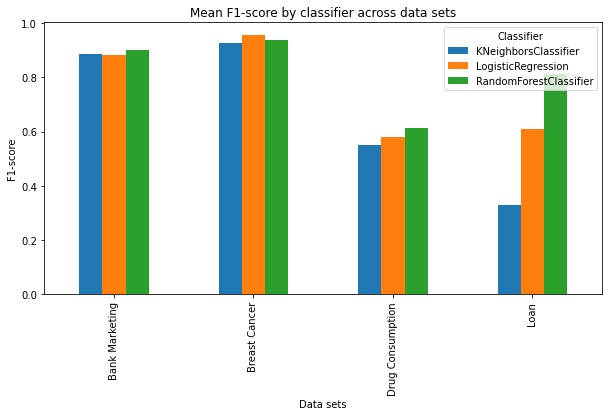

In [326]:
#For each dataset, plot the average F1-score for each classifier, two different bars for each dataset
data.groupby(['dataset', 'Classifier'])['Mean F1-score'].mean().unstack().plot(kind='bar', figsize=(10,5))
plt.title('Mean F1-score by classifier across data sets')
plt.ylabel('F1-score')
plt.xlabel('Data sets')
plt.show()

    

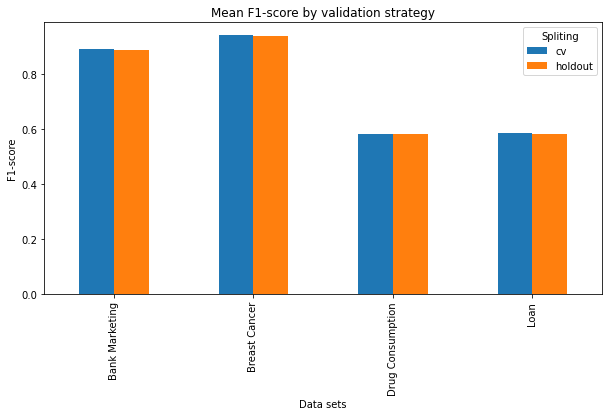

In [327]:
#For each dataset, plot the average F1-score for each classifier, two different bars for each dataset
data.groupby(['dataset', 'Spliting'])['Mean F1-score'].mean().unstack().plot(kind='bar', figsize=(10,5))
plt.title('Mean F1-score by validation strategy')
plt.ylabel('F1-score')
plt.xlabel('Data sets')
plt.show()


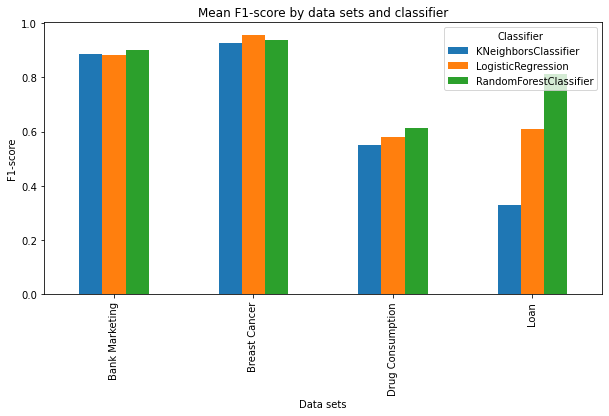

In [328]:
data.groupby(['dataset', 'Classifier'])['Mean F1-score'].mean().unstack().plot(kind='bar', figsize=(10,5))
plt.title('Mean F1-score by data sets and classifier')
plt.ylabel('F1-score')
plt.xlabel('Data sets')
plt.show()

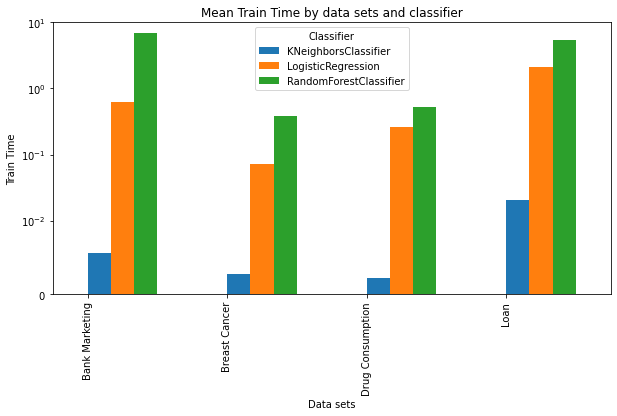

In [329]:
#Log the train time
#data['Mean Train Time'] = -np.log(data['Mean Train Time'])

#Adjust the y axis to log scale
data.groupby(['dataset', 'Classifier'])['Mean Train Time'].mean().unstack().plot(kind='bar', align='edge', figsize=(10,5))
plt.title('Mean Train Time by data sets and classifier')
plt.ylabel('Train Time')
plt.xlabel('Data sets')
plt.yscale('symlog', linthresh=0.01)
plt.ylim(0, 10)
plt.show()



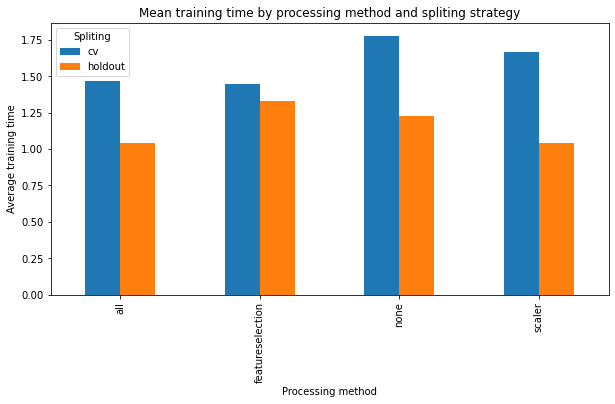

In [330]:
#Plot only training time for "processing method", one bar where "processing method" is "none" and one bar where "processing method" is "all"
#Exclude "random forest" from the plot
#data[data['Classifier'] != 'RandomForestClassifier'].groupby(['Processing method', 'Spliting'])['Mean Train Time'].mean().unstack().plot(kind='bar', figsize=(10,5))
data.groupby(['Processing method', 'Spliting'])['Mean Train Time'].mean().unstack().plot(kind='bar', figsize=(10,5))

plt.title('Mean training time by processing method and spliting strategy')
plt.ylabel('Average training time')
plt.xlabel('Processing method')
plt.show()


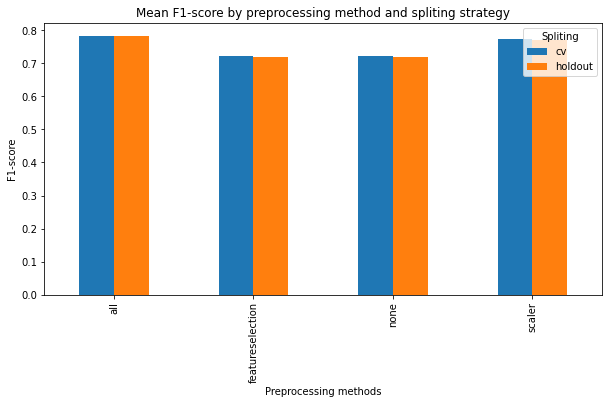

In [331]:
#Compare the preprocessing steps, each bar one category of preprocessing
data.groupby(['Processing method', 'Spliting'])['Mean F1-score'].mean().unstack().plot(kind='bar', figsize=(10,5))
plt.title('Mean F1-score by preprocessing method and spliting strategy')
plt.ylabel('F1-score')
plt.xlabel('Preprocessing methods')
plt.show()


In [332]:
#When data set==Loan, select the highest F1-score with spliting strategy==holdout
data[(data['dataset'] == 'Loan') & (data['Spliting'] == 'holdout')].sort_values(by=['Mean F1-score'], ascending=False).head(1)
data[(data['dataset'] == 'Loan') & (data['Spliting'] == 'cv')].sort_values(by=['Mean F1-score'], ascending=False).head(1)



,dataset,Spliting,Classifier,Processing method,Mean F1-score,Dev F1-score,Mean Preprocess Time,Mean Train Time
47,Loan,cv,LogisticRegression,all,0.871885,0.008453,1.122355,1.131769


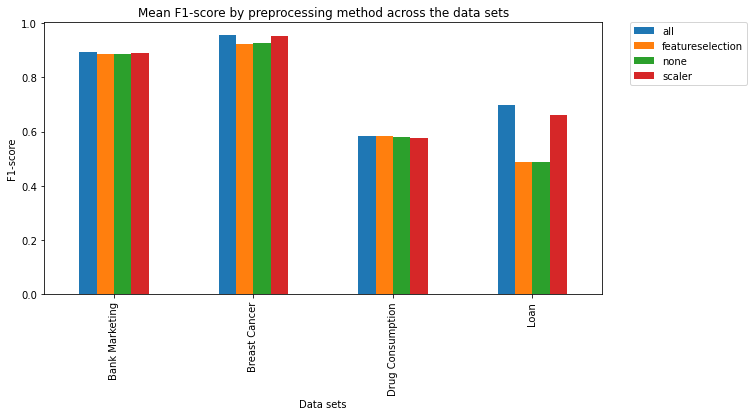

In [333]:
#Compare the preprocessing steps, each bar one category of preprocessing

data.groupby(['dataset', 'Processing method'])['Mean F1-score'].mean().unstack().plot(kind='bar', figsize=(10,5))
plt.title('Mean F1-score by preprocessing method across the data sets')
plt.ylabel('F1-score')
plt.xlabel('Data sets')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()



Text(0, 0.5, 'Dev F1-score')

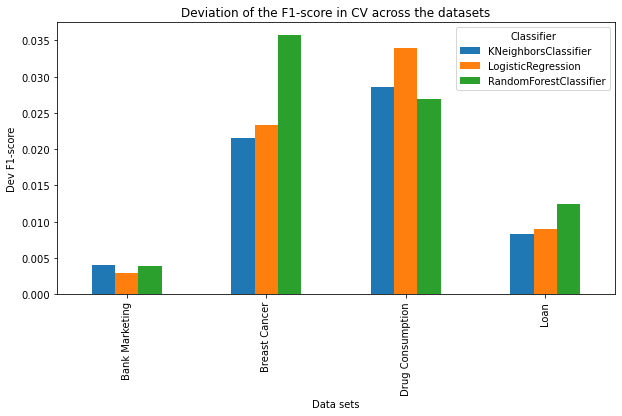

In [334]:
##Only where spliting == CV, plot the dev F1-score for each classifier, two different bars for each dataset
data[data['Spliting'] == 'cv'].groupby(['dataset', 'Classifier'])['Dev F1-score'].mean().unstack().plot(kind='bar', figsize=(10,5))
plt.title('Deviation of the F1-score in CV across the datasets')
plt.xlabel('Data sets')
plt.ylabel('Dev F1-score')


## Model tuning

In [335]:
##Print for each dataset the row with the top 3 F1-scores
for dataset in dataset_names:
    print(data[data['dataset'] == dataset].head(3))
    print("\n\n")
    




          dataset Spliting            Classifier Processing method  \
11  Breast Cancer  holdout    LogisticRegression               all   
8   Breast Cancer  holdout    LogisticRegression            scaler   
10  Breast Cancer  holdout  KNeighborsClassifier               all   

    Mean F1-score  Dev F1-score  Mean Preprocess Time  Mean Train Time  
11       0.985023      0.012229              0.091289         0.009250  
8        0.975056      0.015852              0.007712         0.019498  
10       0.949846      0.052558              0.088133         0.000774  



   dataset Spliting              Classifier Processing method  Mean F1-score  \
35    Loan  holdout      LogisticRegression               all       0.863712   
32    Loan  holdout      LogisticRegression            scaler       0.853114   
33    Loan  holdout  RandomForestClassifier               all       0.824782   

    Dev F1-score  Mean Preprocess Time  Mean Train Time  
35      0.007584              1.516483       

In [336]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline


param_space = {
    'RandomForestClassifier': {
        'model__n_estimators': [10, 50, 100, 200, 500],
        'model__max_depth': [None, 5, 10, 20, 50],
        'model__min_samples_split': [2, 5, 10, 20, 50],
        'model__min_samples_leaf': [1, 2, 5, 10, 20],
        'model__max_features': ['auto', 'sqrt', 'log2', None],
        'model__bootstrap': [True, False]
    },
    'KNeighborsClassifier': {
        'model__n_neighbors': [1, 2, 5, 10, 20, 50],
        'model__weights': ['uniform', 'distance'],
        'model__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
        'model__leaf_size': [10, 20, 30, 50],
        'model__p': [1, 2]
    },
    'LogisticRegression': {
        'model__penalty': ['l2'],
        'model__C': [0.1, 0.5, 1.0, 2.0, 5.0],
        'model__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
        'model__max_iter': [10, 50, 100, 200, 500]
    }
}

def random_search(X, y, classifier, param_space, n_iter=10, cv=5):
    pipe = Pipeline(steps=[('scaler', StandardScaler()), ('model', classifier)])
    clf = RandomizedSearchCV(pipe, param_space, n_iter=n_iter, cv=cv, verbose=1, n_jobs=-1,random_state=42)
    clf.fit(X, y)
    for i in range(n_iter):
        print(f"Parameters combination {i+1}: {clf.cv_results_['params'][i]}")
        print(f"Mean cross-validated score for that combination: {clf.cv_results_['mean_test_score'][i]}")
        print(f"Mean cross-validated fit time for that combination: {clf.cv_results_['mean_fit_time'][i]}\n")       

    return clf.best_params_

In [337]:
X = bank.drop("target", axis=1)
y = bank["target"]

def cv_pipeline(model, X, y, cv=5):
    pipe = Pipeline(steps=[('scaler', StandardScaler()), ('model', model)])
    scores = cross_val_score(pipe, X, y, scoring='f1', cv=cv)
    return (scores)


classifiers = [RandomForestClassifier(), KNeighborsClassifier(), LogisticRegression()]

for classifier in classifiers:
    print(classifier)
    print("Score:" ,cv_pipeline(classifier, X, y).mean())

random_search(X, y, RandomForestClassifier(), param_space['RandomForestClassifier'], n_iter=10, cv=5)
random_search(X, y, KNeighborsClassifier(), param_space['KNeighborsClassifier'], n_iter=10, cv=5)
random_search(X, y, LogisticRegression(), param_space['LogisticRegression'], n_iter=10, cv=5)

RandomForestClassifier()
Score: 0.6096563806441238
KNeighborsClassifier()


KeyboardInterrupt: 